# Agressive Social Media Text Processing



## Project Main code
1. Read in the dataset
1. Pre-process Dataset
1. Create Labels for classification
1. Build Model 1
1. Train Model 1
1. Display Accuracy
1. Build Model 2
1. Train Model 2
1. Display Accuracy
1. Transfer Learning

## Prepare Google Drive and Filename

In [1]:
#All library imports are here
import numpy as np
import pandas as pd
import re
import string
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import keras
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.python.client import device_lib
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers.core import Dense, Dropout, Activation, Lambda
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [2]:
dataset_file = 'D:/project/ece570nlp/dataSet.csv'

## Read Dataset



In [3]:
#In this section we Read the dataset from the Paper

# Data is stored in csv format

# Load CSV using Pandas

filename = dataset_file
names = ['id', 'post', 'label']
df_original = pd.read_csv(filename, names=names, encoding='UTF-8')
print(df_original.shape)

(12000, 3)


## Print the first 10 lines of the data as an example

In [4]:
first_10_rows = df_original.head(10)
print(first_10_rows)

                            id  \
0   facebook_corpus_msr_401470   
1   facebook_corpus_msr_386695   
2   facebook_corpus_msr_373389   
3   facebook_corpus_msr_917635   
4   facebook_corpus_msr_382517   
5   facebook_corpus_msr_403274   
6  facebook_corpus_msr_1723083   
7   facebook_corpus_msr_325257   
8    facebook_corpus_msr_23447   
9  facebook_corpus_msr_1477104   

                                                post label  
0  Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...   OAG  
1  Bhai 60sal pehle desh me kya tha pehle pta kro...   CAG  
2  chutiya friday ko isliye releae krte kyoki wee...   CAG  
3                                         जय मोदीराज   CAG  
4     UPA walo ne bahot kuch kr diya tha desh k liye   CAG  
5  Pan ko Aadhar se link ki zarurat kuy hai? Supr...   CAG  
6  काकर पाथर जोड़ के मस्जिद लई बनाय।\n\nता चढ़ि मुल...   OAG  
7  Us raat tere papa k jageh mera sperm gya tha u...   OAG  
8                                       गटर के कीड़े   OAG  
9  Waise bandhu

## Read the processed data back to a dataframe

In [5]:
dataset_processed_file = 'D:/project/ece570nlp/DataSetProcessed.csv'

In [6]:
filename = dataset_processed_file
header = ['id', 'post', 'label']
df_processed = pd.read_csv(filename, names=header)
print(df_processed.shape)
print(df_processed.head(10))

(11999, 3)
                             id  \
0   facebook_corpus_msr_401470    
1   facebook_corpus_msr_386695    
2   facebook_corpus_msr_373389    
3   facebook_corpus_msr_917635    
4   facebook_corpus_msr_382517    
5   facebook_corpus_msr_403274    
6  facebook_corpus_msr_1723083    
7   facebook_corpus_msr_325257    
8    facebook_corpus_msr_23447    
9  facebook_corpus_msr_1477104    

                                                post label  
0   Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...   OAG  
1   Bhai 60sal pehle desh me kya tha pehle pta kr...   CAG  
2   chutiya friday ko isliye releae krte kyoki we...   CAG  
3                                       jai modiraj    CAG  
4    UPA walo ne bahot kuch kr diya tha desh k liye    CAG  
5   Pan ko Aadhar se link ki zarurat kuy hai? Sup...   CAG  
6   kaakar pathar jod ke masjid lai banaay. ta ch...   OAG  
7   Us raat tere papa k jageh mera sperm gya tha ...   OAG  
8                                    gater ke keede   

## Split the dataset into training and test data

In [7]:
df_processed = df_processed.iloc[: , 1:]  # Drop first column
print(df_processed.shape)

# Save without ID to csv file
file_no_id = 'D:/project/ece570nlp/fileNoID.csv'
df_processed.to_csv(file_no_id, index=False, header=False)

# Decide on a percentage split 70/30
#msk = np.random.rand(len(df)) < 0.7
#train_df = df_processed[msk]
#test_df = df_processed[~msk]

#print(train_df.shape)
#print(test_df.shape)

#print(train_df.head(10))

(11999, 2)


In [8]:
file_no_id = 'D:/project/ece570nlp/fileNoID.csv'
data_cleanedup = 'D:/project/ece570nlp/datacleanedup.csv'

In [9]:
header = ['post', 'label']
df_pretoken = pd.read_csv(data_cleanedup, header=None, names=header)
print(df_pretoken.shape)

X_pretoken = df_pretoken['post']
Y_pretoken = df_pretoken['label']

print(X_pretoken.shape)
print(Y_pretoken.shape)

tokenizer = Tokenizer(num_words=4000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
tokenizer.fit_on_texts(X_pretoken)
#print(tokenizer.word_index)

X = tokenizer.texts_to_sequences(X_pretoken)
#X = word_tokenize(str(X_pretoken))  # Using NLTK
#print(X)


sum_tot = 0
for seq in X:
    sum_tot += len(seq)

print(float(sum_tot/11634.0))

new_x = []
new_y = []

for i in range(0, len(X)):
    if len(X[i]) < 400:
        new_x.append(X[i])
        new_y.append(Y_pretoken[i])

print(len(new_x))
print(len(new_y))

X = pad_sequences(new_x)
Y = pd.get_dummies(new_y)

print(X.shape)
print(Y.shape)

#print(X)
#print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


X_train_tensor = torch.Tensor(X_train)
Y_train_tensor = torch.Tensor(np.array(Y_train))

X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)

X_test_tensor = torch.Tensor(X_test)
Y_test_tensor = torch.Tensor(np.array(Y_test))

X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)


(11788, 2)
(11788,)
(11788,)
22.9778236204229
11773
11773
(11773, 387)
(11773, 3)
(9418, 387)
(9418, 3)
(2355, 387)
(2355, 3)


NameError: name 'device' is not defined

Build the MLP Network

In [11]:

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Deep Neural Network "MLP": multi layer Perceptron
#with tf.device('/GPU:0'):
model = Sequential()


model.add(Dense(256, input_dim=X_train.shape[1]))

# 0.42 accuracy.
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print("Training...")
model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_split=0.2)

print("Generating test predictions...")
preds = model.predict(X_test, verbose=0)
print(preds)

# Evaluating the model
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8723625169893544401
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10043260928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6798829934341024794
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1
Training...
Epoch 1/5
236/236 [==============================] - 3s 4ms/step - loss: 49.3329 - accuracy: 0.3809 - val_loss: 1.8381 - val_accuracy: 0.3848
Epoch 2/5
236/236 [==============================] - 1s 3ms/step - loss: 2.2698 - accuracy: 0.3945 - val_loss: 1.0719 - val_accuracy: 0.4071
Epoch 3/5
236/236 [==============================] - 1s 3ms/step - loss: 1.3235 - accuracy: 0.3973 - val_loss: 1.0547 - val_accuracy: 0.4071
Epoch 4/5
236/236 [==============================] - 1s 3ms/step - loss: 1.1637 - accuracy: 0.4012 - val_loss: 1.0482 - val_acc

In [12]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [13]:
predict = model.predict(X_test)
preds = predict
p = preds

74/74 [==============================] - 0s 2ms/step


In [14]:
tmpMat = np.zeros((len(Y_test), 3), dtype=int)
#print(tmpMat.shape)
for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

test_y = Y_test.to_numpy()



print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



# OF CAG
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


# Of class NAG
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

# Of class OAG
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

0.564612612222589
0.4148619957537155
0.24378579952887636
0.7573939285707842
0.4148619957537155
0.2437861012494078
0.6516020032365524
0.8072186836518047
0.7211102996344364
0.7616524793142448
0.6076433121019108
0.45979269369900566


c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
#CNN
# CNN: ConvNeuralNets

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

In [16]:
from keras.layers.convolutional import Convolution1D
from keras import backend as K

print('Build model...')
model = Sequential()
model.add(Embedding(4000, 128))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(4000, 128, 
                        activation='relu'))

def max_1d(X_train):
    return K.max(X_train, axis=1)

model.add(Lambda(max_1d, output_shape=(nb_filter,)))
model.add(Dense(hidden_dims)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [17]:
print('Train...')
model.fit(X_train, Y_train, batch_size=100, epochs=2,
          validation_split=0.2)
score, acc = model.evaluate(X_test, Y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/2
76/76 [==============================] - 211s 2s/step - loss: 0.6398 - accuracy: 0.4208 - val_loss: 0.5740 - val_accuracy: 0.4931
Epoch 2/2
74/74 [==============================] - 8s 101ms/step - loss: 0.5240 - accuracy: 0.5851
Test score: 0.5239724516868591
Test accuracy: 0.5851380228996277


In [18]:
predict = model.predict(X_test)
test_y = Y_test.to_numpy()
tmpMat = np.zeros((len(Y_test), 3), dtype=int)

for i in range(0,len(predict)):
    if(predict[i][0] > predict[i][1] and predict[i][0] > predict[i][2]):
        tmpMat[i][0]=1
    elif(predict[i][1] > predict[i][0] and predict[i][1] > predict[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1
        
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))

print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))

print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

74/74 [==============================] - 7s 93ms/step
0.6184213902166585
0.5851380042462845
0.5766898025638827
0.6497355892414785
0.6067940552016985
0.6053642154024319
0.8292502781534452
0.8450106157112527
0.8230072559993208
0.7140650532376177
0.7184713375796178
0.7096931295772451


## LSTM

In [19]:
# LSTM Model for prediction
embed_dim = 128
lstm_out = 196
batch_size = 100

model = Sequential()
#model.add(Embedding(4000, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(Embedding(4000, embed_dim,input_length = X.shape[1]))
#model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 387, 128)          512000    
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense_5 (Dense)             (None, 3)                 591       
                                                                 
Total params: 767,391
Trainable params: 767,391
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 2, verbose = 2)

Epoch 1/2
95/95 - 4s - loss: 0.9726 - accuracy: 0.4816 - 4s/epoch - 41ms/step
Epoch 2/2
95/95 - 2s - loss: 0.7769 - accuracy: 0.6350 - 2s/epoch - 23ms/step


In [21]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

24/24 - 1s - loss: 0.8816 - accuracy: 0.5843 - 661ms/epoch - 28ms/step
Score: 0.88
Validation Accuracy: 0.58


In [22]:
p = model.predict(X_test)

74/74 [==============================] - 1s 12ms/step


In [23]:
tmpMat = np.zeros((len(Y_test), 3), dtype=int)

for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

test_y = Y_test.to_numpy()

# For LSTM model
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))

# Of Class CAG
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))

# Of class NAG
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

# Of class OAG
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

0.5917995077059791
0.5842887473460722
0.5846419471518496
0.6486808198223001
0.640764331210191
0.6430169694082171
0.8265756703758201
0.8195329087048833
0.8227128891568494
0.7029169958869594
0.70828025477707
0.7018540430125413


## Naive Bayes

In [24]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=X_train.shape[1], out_features=4000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4000, out_features=3),
)

model = model.to(device)


ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

kl_weight = 0.1

for step in range(3000):
    pre = model(X_train_tensor)
    ce = ce_loss(pre, Y_train_tensor)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = Y_train_tensor.size(0)
#correct = (predicted == Y_train_tensor).sum()
#print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))


- CE : 4.24, KL : 0.46


In [26]:
model.eval()
predict = model(X_test_tensor)
preds = predict
p = preds

In [27]:
tmpMat = np.zeros((len(Y_test_tensor), 3), dtype=int)
#print(tmpMat.shape)
for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1


Y_test_tensor = Y_test_tensor.cpu().detach()
test_y = Y_test_tensor.numpy()



print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



# OF CAG
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


# Of class NAG
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

# Of class OAG
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

0.4150505020856367
0.4220806794055202
0.3529458830358359
0.5447077314024311
0.4653927813163482
0.41799338117676954
0.7518767875744102
0.7987261146496816
0.7594931836701142
0.5225647022187301
0.5800424628450106
0.5097267398257043


## SVM

In [65]:
#Import svm model
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

# Decide on a percentage split 70/30
msk = np.random.rand(len(df_pretoken)) < 0.7
train_df = df_pretoken[msk]
test_df = df_pretoken[~msk]

print(train_df.shape)
print(test_df.shape)

#print(train_df.head(10))

vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(train_df['post'])
test_features = vectorizer.transform(test_df['post'])
print(train_features.shape)

#Create a svm Classifier
model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
model.fit(train_features, train_df['label'])

#Predict the response for test dataset
predict = model.predict(test_features)

(8202, 2)
(3586, 2)
(8202, 4302)


In [122]:
preds = predict
p = preds

In [123]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_df['label'],predict))

Accuracy: 0.5755716675962075


## Transfer Learning

### Get the indic bert transformer

In [29]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Customize the Transformer for the required input and output

In [30]:
model.embeddings.word_embeddings = nn.Embedding(4000,128,padding_idx=0)
model.pooler = nn.Linear(in_features = 768, out_features=3)

print(model)



AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(4000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
       

### Display a few lines of the dataset

In [31]:
df_pretoken.head

<bound method NDFrame.head of                                                     post  label
0       Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...      1
1       Bhai 60sal pehle desh me kya tha pehle pta kr...      0
2       chutiya friday ko isliye releae krte kyoki we...      0
3                                           jai modiraj       0
4        UPA walo ne bahot kuch kr diya tha desh k liye       0
...                                                  ...    ...
11783       Pak congress ne hi di hui den hai duniya ko       0
11784   or shart yah hogi ki un fiter jet plance kaa ...      1
11785   abhi thodi der main grahamantri ji kadi ninda...      0
11786   mai bas main baitha tha  mere bagal main ek a...      1
11787   Aziz Hala thodi si chook kar di tuune  ajij h...      1

[11788 rows x 2 columns]>

### Split the training and testing datasets


In [32]:
# split train dataset into train, validation and test sets
df_pretoken['label'] = df_pretoken['label'].replace([" CAG"," OAG"," NAG"],[0,1,2]) 
train_text, temp_text, train_labels, temp_labels = train_test_split(df_pretoken['post'], df_pretoken['label'], random_state=2018, test_size=0.3, stratify=df_pretoken['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

print(df_pretoken.head)

<bound method NDFrame.head of                                                     post  label
0       Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...      1
1       Bhai 60sal pehle desh me kya tha pehle pta kr...      0
2       chutiya friday ko isliye releae krte kyoki we...      0
3                                           jai modiraj       0
4        UPA walo ne bahot kuch kr diya tha desh k liye       0
...                                                  ...    ...
11783       Pak congress ne hi di hui den hai duniya ko       0
11784   or shart yah hogi ki un fiter jet plance kaa ...      1
11785   abhi thodi der main grahamantri ji kadi ninda...      0
11786   mai bas main baitha tha  mere bagal main ek a...      1
11787   Aziz Hala thodi si chook kar di tuune  ajij h...      1

[11788 rows x 2 columns]>


### Check the Bert Model

In [33]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[2, 255, 54, 33, 8, 121763, 10903, 55053, 116316, 3, 0], [2, 491, 168, 15527, 30, 197789, 33, 8, 121763, 10903, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Tokenize the sentences

<AxesSubplot:>

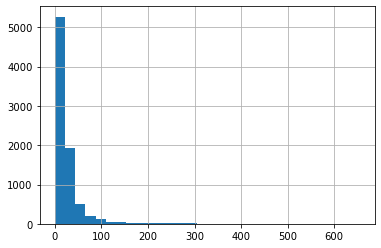

In [34]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [35]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

### Convert list to tensors

In [36]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


### Create Training and validation Set

In [53]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Define model architecture

In [58]:
# freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

# push the model to GPU
#model = model.to(device)

print(model.config.vocab_size)

200000


### Bert model

### Pass the model

### Optimizer

In [39]:
# optimizer from hugging face transformers
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

### Class implementation

In [40]:
from sklearn.utils.class_weight import compute_class_weight



class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )



print("Class Weights:",class_weights)

Class Weights: [0.82124017 0.82369971 1.75965025]


### Class weight to tensor

In [41]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
#weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

### Fine tune indic bert

In [55]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    #batch = [r.to(device) for r in batch]
    #batch = [for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

### Evaluation Function

In [56]:
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time

# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
         
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    #batch = [t.to(device) for t in batch]
    #batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start fine tuning bert model

In [57]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 2

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2


IndexError: index out of range in self